In [2]:
import torch, torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import sys
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
eeg_emo0 = np.load('Data/eeg_emo_chan.npy') #16 important channel
targets = np.load('Data/targets.npy')
print(eeg_emo0.shape)
print(targets.shape)

(1280, 16, 8064)
(1280, 4)


In [4]:
eeg_emo0 = eeg_emo0[:,:,384:] #cut first 3 sec

In [5]:
import mne 
eeg_emo = mne.filter.filter_data(eeg_emo0, sfreq=128, l_freq=4.5, h_freq=45)

Setting up band-pass filter from 4.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 213 samples (1.664 sec)



In [6]:
stft_emo = np.zeros([1280,16,129,60])

for i in range(stft_emo.shape[0]):
    xx = mne.time_frequency.stft(eeg_emo[i],wsize=256,verbose ='critical');
    stft_emo[i] = xx
stft_emo.shape

<ipython-input-6-7bb2887d1ecc>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_emo[i] = xx


(1280, 16, 129, 60)

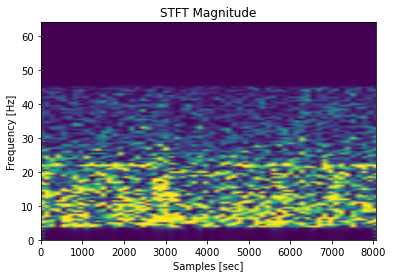

In [7]:
from scipy import signal
plt.pcolormesh(np.linspace(0, 8064 , num= stft_emo[0].shape[2]),
               np.linspace(0, 64 , num= stft_emo[0].shape[1]),
               np.abs(stft_emo[0][0])
               ,vmin=0, 
               vmax=4, 
               shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples [sec]')
plt.show()

In [8]:
stft_emo.shape

(1280, 16, 129, 60)

In [8]:
valence = []
mean_valence = np.mean(targets[:,0])
for i in range(targets.shape[0]):
    if targets[i,0] < mean_valence :
        valence.append(0)
    else :
        valence.append(1)
valence = np.array(valence)
valence.shape

(1280,)

In [9]:
from tensorflow.keras.utils import to_categorical
valence = to_categorical(valence)
valence.shape

(1280, 2)

In [39]:
train_size = 0.85
val_size = 0.1
idx = np.arange(0,stft_emo.shape[0],1)
ts = int(train_size*stft_emo.shape[0]) 
vs = int(val_size*stft_emo.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [40]:
x_train = stft_emo[idx_train]
x_val = stft_emo[idx_val]
x_test = stft_emo[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)

print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (1088, 16, 129, 60)
x_val (128, 16, 129, 60)
x_test (64, 16, 129, 60)
y_train (1088, 2)
y_val (128, 2)
y_test (64, 2)


In [41]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [63]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 64
def dataload(X, y):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y)
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return dataset_tensor
    #return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataload(x_train, y_train), batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataload(x_val, y_val), batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

# STFT+CONV2D

In [65]:
num_epochs = 300
num_classes = 2
learning_rate = 0.0001
cuda = 3

In [66]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        

        #stft_data.shape[1] = number of channel
        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        """self.fc = nn.Sequential(nn.Linear(128*16*7,512),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(512,250),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(250,125),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(125,50),nn.ReLU(),nn.Dropout(0.1),
                               nn.Linear(50,num_classes),nn.Dropout(0.1))"""
        
        self.fc = nn.Linear(128*32*15, num_classes)
        #self.fc = nn.Sequential(nn.Linear(128*16*31,128),nn.ReLU(),nn.Dropout(0.1),
                               #nn.Linear(128,num_classes),nn.Dropout(0.1))
        self.drop_out = nn.Dropout(p=0.5)
        #self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        #out = self.layer3(out)
        #out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        #out = self.softmax(out)
        return out

In [67]:
model = ConvNet(num_classes).cuda(cuda)

In [68]:
# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

In [47]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc/2

In [48]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        features   = features.cuda(cuda)
        label = label.cuda(cuda)        
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        l2_lambda = 0.0001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [49]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 
            features   = features.cuda(cuda)
            label = label.cuda(cuda)

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [69]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    if epoch%50==0: 
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.947 | Train Acc: 50.83%
	 Val. Loss: 0.697 |  Val. Acc: 47.66%
Epoch: 51 | Train Loss: 0.547 | Train Acc: 77.39%
	 Val. Loss: 0.746 |  Val. Acc: 60.94%
Epoch: 101 | Train Loss: 0.353 | Train Acc: 89.25%
	 Val. Loss: 0.981 |  Val. Acc: 58.59%
Epoch: 151 | Train Loss: 0.233 | Train Acc: 95.13%
	 Val. Loss: 1.152 |  Val. Acc: 64.06%
Epoch: 201 | Train Loss: 0.173 | Train Acc: 96.65%
	 Val. Loss: 1.377 |  Val. Acc: 59.77%
Epoch: 251 | Train Loss: 0.123 | Train Acc: 98.81%
	 Val. Loss: 1.513 |  Val. Acc: 60.16%


Text(0, 0.5, 'loss')

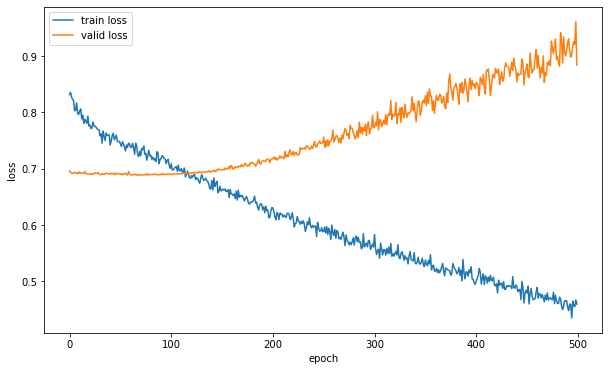

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

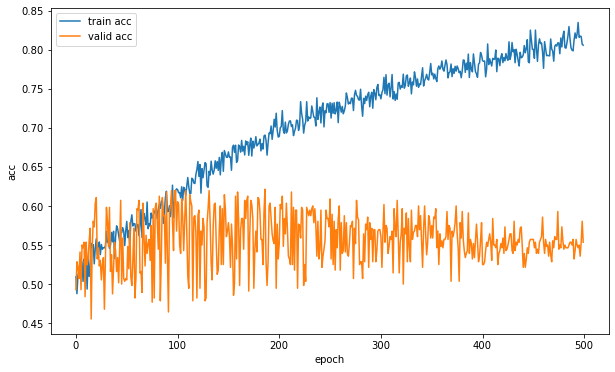

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

In [70]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.663 | Test Acc: 60.94%


# CONV1D+LSTM

In [25]:
train_size = 0.85
val_size = 0.1
idx = np.arange(0,eeg_emo.shape[0],1)
ts = int(train_size*eeg_emo.shape[0]) 
vs = int(val_size*eeg_emo.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [26]:
x_train = eeg_emo[idx_train]
x_val = eeg_emo[idx_val]
x_test = eeg_emo[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)

print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (1088, 16, 7680)
x_val (128, 16, 7680)
x_test (64, 16, 7680)
y_train (1088, 2)
y_val (128, 2)
y_test (64, 2)


In [27]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 20
def dataload(X, y):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y)
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return dataset_tensor
    #return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(dataload(x_train, y_train), batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataload(x_val, y_val), batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataload(x_test, y_test), batch_size=batch_size, shuffle=False)

In [28]:
#model hyperparameters
hidden_dim1 = 64
embed_dim = x_train.shape[2]
output_dim = 2
num_layers = 2
bidirectional = True
dropout = 0.2
cuda = 2
#training hyperparameters
num_epochs =300
lr=0.001

In [29]:
import torch.nn as nn
from torch.nn import functional as F

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.layer1 = nn.Sequential(
            nn.Conv1d(16,64, 4, stride=2),
            nn.ReLU(),
            nn.Dropout(p=0.5))      
        self.lstm = nn.LSTM(3839, hidden_dim1, num_layers=num_layers,
                    bidirectional=bidirectional, 
                    dropout=dropout,
                    batch_first=True)
        self.fc = nn.Linear(hidden_dim1*2, output_dim)   
        self.fc1 = nn.Linear(15356, output_dim)
    
    
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    
    def forward(self, x):
        out0 = self.layer1(x)
        out,(hn, cn) = self.lstm(out0)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        
        attn_output, attention = self.attention_net(out, hn)
        #out0 = out0.reshape(out0.size(0), -1)
        return self.fc(attn_output)

In [30]:
model = LSTM().cuda(cuda)

In [31]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-5)

In [32]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc/2

In [33]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
        features   = features.cuda(cuda)
        label = label.cuda(cuda)
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [34]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 
            features   = features.cuda(cuda)
            label = label.cuda(cuda)

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [35]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    if epoch%50==0:
        
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 6.928 | Train Acc: 51.41%
	 Val. Loss: 0.693 |  Val. Acc: 50.18%
Epoch: 51 | Train Loss: 0.357 | Train Acc: 93.55%
	 Val. Loss: 1.514 |  Val. Acc: 50.71%
Epoch: 101 | Train Loss: 0.286 | Train Acc: 97.09%
	 Val. Loss: 1.708 |  Val. Acc: 54.29%
Epoch: 151 | Train Loss: 0.247 | Train Acc: 98.41%
	 Val. Loss: 2.076 |  Val. Acc: 55.36%
Epoch: 201 | Train Loss: 0.223 | Train Acc: 98.36%
	 Val. Loss: 1.830 |  Val. Acc: 62.14%
Epoch: 251 | Train Loss: 0.236 | Train Acc: 97.73%
	 Val. Loss: 2.112 |  Val. Acc: 54.64%
Epoch: 301 | Train Loss: 0.207 | Train Acc: 99.18%
	 Val. Loss: 2.113 |  Val. Acc: 52.86%
Epoch: 351 | Train Loss: 0.356 | Train Acc: 94.91%
	 Val. Loss: 1.390 |  Val. Acc: 55.71%
Epoch: 401 | Train Loss: 0.286 | Train Acc: 95.95%
	 Val. Loss: 2.053 |  Val. Acc: 52.86%
Epoch: 451 | Train Loss: 0.283 | Train Acc: 97.14%
	 Val. Loss: 1.916 |  Val. Acc: 54.29%


Text(0, 0.5, 'loss')

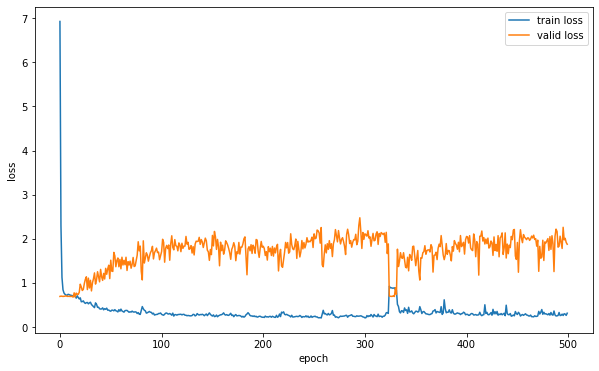

In [36]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

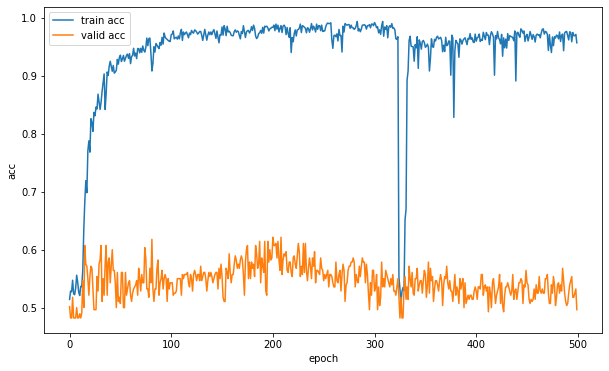

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

In [38]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.701 | Test Acc: 48.13%
